# Práctica - Redes Neuronales TensorFlow
En esta práctiva vamos a ver como implementar redes neuronales profundas con la librería tensorflow, que es en la cual se apoya KERAS para diseñar las redes neuronales.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

In [4]:
import keras
from keras.utils import to_categorical
from keras import layers

In [5]:
from tensorflow.keras import regularizers
import tensorflow.keras as tk
from sklearn.metrics import roc_auc_score

In [6]:
import tensorflow as tf


## Deep Learning con tensorflow
Tensorflow es una librería abierta desarrollada para cálculo numérico, especialmente para el diseño de redes neuronales, representada gráficamente mediante nodos y ejes. Los nodos representan operaciones matemáticas, como productos escalares, y los ejes o líneas en el grafo representan el movimiento de los tensores. El tensor es un objeto diseñado por tensorflow donde se encuentra la información que maneja la red: datos en cada capa o en cada nodo. Por eso se dice que los datos fluyen a través del grafo o que los tensores fluyen (tensorflow).

Tensorflow es una de las librerías más utilizadas para el diseño de redes neuronales y además, la librería que hemos visto en prácticas anteriores (KERAS), se apoya en tensorflow como lenguage de computación. Por estos motivos en esta sesión vamos a adentrarnos en tensorflow y descubrir sus funcionalidades básicas.

Hay que tener en cuenta que la programación en tensorflow se hace en dos etapas: 1) Se construye un grafo computacional donde las operaciones simbólicas aparecen en forma de nodo en el gráfico. 2) Se corre el grafo computacional.

### Ejemplo sencillo
La naturaleza de los tensores puede ser de 3 formas distintas: constante, placeholder o variable. 1) Si un nodo es una CONSTANTE, entonces dicho valor se mantiene igual siempre. Es decir, no cambia su valor durante el entrenamiento. 2) Si un nodo es un PLACEHOLDER, entonces este valor es suplementado por el usuario cuando se corra el gráfico. Por ejemplo, los datos de entrenamiento se consideran placeholders. 3) Si un nodo es una VARIABLE, entonces dicho nodo cambiará su valor a lo largo del proceso de entrenamiento. Este es el caso de los coeficientes o parámetros del modelo.

Vamos a ver un ejemplo muy simple para ilustrar el concepto:

In [7]:
import tensorflow as tf

In [8]:
print(tf.__version__)

2.11.0


In [9]:
a = tf.constant(5)
b = tf.constant(4)
c = tf.multiply(a, b)

print(c)

tf.Tensor(20, shape=(), dtype=int32)


2024-02-14 17:33:55.801109: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-02-14 17:33:55.801126: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-02-14 17:33:55.801139: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (aura): /proc/driver/nvidia/version does not exist
2024-02-14 17:33:55.801360: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# Convertir a un valor de numpy para imprimir en Python
print(c.numpy())

20


Vemos que “c” no es el un valor numérico que resulta de multiplicar 4x5, sino un tensor. Esto se debe a que estamos en la etapa de construcción del grafo. Para obtener el resultado de la multiplicación habría que correr el grafo. Para correr el grafo hay que iniciar antes una sesión y después hacer sess.run(c):

In [11]:
# Desactivamos el modo de ejecucion eager para poder abrir sesiones sin el with
tf.compat.v1.disable_eager_execution()

In [12]:
sess = tf.compat.v1.Session()

a = tf.constant(5)
b = tf.constant(4)
c = tf.multiply(a, b)
    
resultado = sess.run(c)
print(resultado)

sess.close()

20


2024-02-14 17:33:56.637483: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


¿Qué hubiese pasado si el nodo “a” en vez de ser una constante hubiese sido un placeholder*? En este caso el valor de “a” lo tendría que haber introducido el usuario cuando se hubiese querido correr el gráfico.

*Un "placeholder" o "marcador de posición" es una variable en TensorFlow a la cual se le asignarán datos en algún momento más adelante. Nos permite crear procesos u operaciones sin la necesidad de tener datos en ese momento. Los datos se alimentan en el marcador de posición cuando se inicia la sesión, y luego se ejecuta la sesión. Podemos alimentar datos en los gráficos de TensorFlow utilizando marcadores de posición

In [13]:
sess = tf.compat.v1.Session()
    
a = tf.compat.v1.placeholder(tf.float32)
b = tf.constant(4.0)
c = tf.multiply(a, b)

resultado = sess.run(c, feed_dict={c: 2})


file_writer = tf.compat.v1.summary.FileWriter("graph", sess.graph)

file_writer.close()
    
sess.close()

Podemos visualizar el gráfico que representa el movimiento de los tensores y las operaciones entre ellos de la siguiente manera:

In [14]:
# Cargar la extensión de TensorBoard para notebook
%load_ext tensorboard

# Iniciar TensorBoard dentro del notebook
%tensorboard --logdir=graph

### Regresión lineal
Ahora vamos a realizar una regresión lineal para introducir el concepto de variable. En una regresión lineal hay que estimar los parámetros que hacen mínima el mean square error. Para estimar los parámetros se recurre al método de gradient descent y se calculan las derivadas con el algoritmo de backpropagation. Por tanto, aunque los parámetros se inicialicen con un determinado valor, estos cambian a lo largo del entrenamiento. Por ello son variables y no constantes ni placeholders. En la siguiente celda vamos a ver como inferir un modelo de regresión lineal con tensorflow. Usamos el dataset MNIST cuyo preproceso ya ha sido explicado en prácticas anteriores.

In [15]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [16]:
train_labels = to_categorical(train_labels, 10)# 10 son el número de clases
test_labels = to_categorical(test_labels, 10)

train_images = train_images / 255
test_images = test_images / 255

Primero, definimos los placeholders, variables y operaciones matemáticas que haya. Es decir, definimos el grafo.

In [17]:
# Definir los placeholders para los datos de entrada x e y_
x = tf.compat.v1.placeholder(tf.float32, shape=(None, 784))
y_ = tf.compat.v1.placeholder(tf.float32, shape=(None, 10))

# Definir las variables W y b con valores iniciales de 0
W = tf.Variable(tf.zeros(shape=(784, 10), dtype=tf.float32))
b = tf.Variable(tf.zeros(shape=(10,), dtype=tf.float32))

# Definir la operación y como la multiplicación matricial de x por W, y luego sumar b
y = tf.matmul(x, W) + b

Ahora definimos la función de error a minimizar. En este caso escribimos la expresión del mean square error, donde “y_” es la observación e “y” es la predicción. Minimizamos entrenando mediante gradient descent(“tf.train.GradientDescentOptimizer(0.01)”, donde 0.01 sería el learning rate). Finalmente inicializamos las variables y iniciamos la sesión.

In [18]:
# Definir la función de pérdida
loss = tf.reduce_mean(tf.square(y - y_))
# Definir el optimizador y la operación de entrenamiento
optimizer = tf.compat.v1.train.GradientDescentOptimizer(0.01)
train_step = optimizer.minimize(loss)
# Inicializar todas las variables globales
init = tf.compat.v1.global_variables_initializer()
# Crear una sesión de TensorFlow y ejecutar la inicialización de variables
sess =  tf.compat.v1.Session()
sess.run(init)

Una vez que está iniciada la sesión podemos correr las operaciones del grafo. Hacemos un bucle para iterar sobre los batches y entrenamos al hacer sess.run(train_step, …). Hay que tener en cuenta que en este caso hay que suplementar tanto x, como y_ ya que ambos son placeholders.

In [19]:
# Definir el número de batches
epochs = 10
batch_size = 100
batchs = int(np.shape(train_images)[0]/100)

# Iterar sobre los batches
for i in range(epochs):
    for bi in range(batchs): # iteraciones
        # Obtener el siguiente batch de datos
        #batch_xs, batch_ys = mnist.train.next_batch(100)
        batch_xs = train_images[batch_size*bi:(bi+1)*batch_size, :, :].reshape(batch_size, 784)
        batch_ys = train_labels[batch_size*bi:(bi+1)*batch_size, :].reshape(batch_size, 10)


        # Ejecutar una iteración de entrenamiento
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})


        # Calcular y mostrar la pérdida en el batch actual
        current_loss = sess.run(loss, feed_dict={x: batch_xs, y_: batch_ys})
        print(current_loss)

0.09779245
0.09630078
0.094765164
0.09342668
0.092650615
0.09211712
0.09108999
0.089420214
0.0887431
0.08840118
0.088751055
0.08789375
0.08630118
0.08483781
0.085966885
0.08582063
0.08468686
0.08335326
0.0836019
0.08278273
0.08229618
0.08130679
0.08172327
0.08198883
0.08148851
0.08012619
0.080523714
0.08070007
0.07815596
0.07987724
0.080746554
0.07916114
0.07912498
0.07852627
0.07850723
0.07842372
0.07694023
0.077332154
0.07664535
0.07764556
0.076311365
0.07674947
0.07443982
0.07667673
0.07634039
0.07241766
0.07493901
0.07526933
0.074933484
0.07425464
0.073293224
0.07356839
0.07198099
0.07159361
0.07089063
0.07151056
0.071652055
0.07408658
0.07325868
0.07163655
0.0688318
0.069248155
0.071107894
0.07065943
0.07086253
0.06765372
0.06915556
0.07192073
0.073671125
0.069065884
0.07025068
0.07114631
0.07541107
0.07388316
0.07116324
0.070414916
0.07063924
0.07112177
0.06793511
0.06709097
0.065834515
0.06845238
0.07021019
0.067721434
0.069843255
0.06435497
0.06890645
0.07128484
0.06988735
0.06

0.05506519
0.050050057
0.043792278
0.050531264
0.040807616
0.038811468
0.050189238
0.049173538
0.047596894
0.055200964
0.049949277
0.052446373
0.051264863
0.055907387
0.04681678
0.05081599
0.060034733
0.058613133
0.048209436
0.04478435
0.039115574
0.049217165
0.043381285
0.043947723
0.044249687
0.044399552
0.04479906
0.053523235
0.05465766
0.04751253
0.053429935
0.04729298
0.04266732
0.04367075
0.044475067
0.040972266
0.04498259
0.049599126
0.050749548
0.05076066
0.04946672
0.046741914
0.04971673
0.042644408
0.047322724
0.058421433
0.053719904
0.05140384
0.04993517
0.04191351
0.045973
0.039780628
0.04448203
0.043801285
0.048018683
0.04343735
0.04390342
0.04237268
0.041774392
0.04242235
0.050395202
0.04875619
0.044524677
0.04859797
0.042610787
0.047579583
0.04041964
0.03867402
0.043247193
0.051072143
0.051240426
0.048674826
0.048396386
0.04389163
0.04115641
0.045132834
0.04115149
0.045644432
0.048638277
0.05411349
0.043875355
0.041912884
0.04020664
0.05019723
0.04662968
0.0471911
0.0443

0.037820406
0.03885151
0.047953222
0.05123385
0.040970847
0.040398795
0.0413464
0.041159973
0.043563303
0.035954505
0.038893532
0.041225877
0.055621758
0.03968637
0.038966347
0.039392445
0.040875904
0.04066004
0.04416122
0.040700633
0.039977532
0.039067756
0.033754487
0.041038487
0.038766313
0.04555687
0.04504003
0.046058457
0.037571035
0.04246858
0.03723236
0.04195736
0.03733019
0.042605948
0.037543006
0.044751387
0.045538183
0.0428462
0.0453917
0.043310672
0.044947196
0.03918625
0.03846437
0.03871039
0.034465108
0.0319493
0.03793281
0.036912132
0.037118174
0.039975885
0.037484013
0.034749914
0.026488498
0.028623799
0.02932106
0.039288737
0.04702301
0.04175313
0.032614734
0.03836708
0.050289102
0.027226992
0.046526916
0.038795263
0.044012953
0.039885566
0.03430989
0.0407954
0.047603805
0.049490016
0.04143082
0.04662944
0.043057404
0.049568657
0.047388818
0.046646096
0.044270813
0.042090263
0.044758048
0.03843879
0.035829894
0.040167045
0.041311726
0.042867735
0.03335463
0.038933586
0.

0.04861393
0.04725446
0.04574825
0.037462402
0.040853873
0.03531501
0.03986697
0.03934887
0.043787476
0.038768996
0.038595255
0.03716527
0.036967903
0.037590273
0.044753976
0.04500146
0.042066682
0.045652885
0.038915444
0.04449141
0.035752013
0.03441999
0.040319968
0.046719033
0.046505414
0.044413123
0.044528734
0.03949099
0.036700122
0.041210845
0.038973227
0.041900076
0.045237795
0.051740386
0.039850507
0.037231546
0.035021804
0.045837477
0.042542815
0.04386358
0.04012416
0.0368194
0.036082625
0.034968827
0.040058654
0.049596358
0.043185737
0.037378877
0.04668746
0.064195015
0.0475542
0.043617073
0.04030569
0.035822906
0.043066528
0.043880638
0.040151812
0.04165651
0.041885685
0.037870225
0.04212365
0.045219496
0.0453287
0.042405922
0.044552293
0.038505662
0.0455619
0.03850013
0.04249908
0.04298574
0.04309986
0.048220422
0.04156189
0.04536831
0.036870897
0.039241
0.039821915
0.040003784
0.03801893
0.038750287
0.040374465
0.037946723
0.04378372
0.04167033
0.037671562
0.03778992
0.0424

0.039310135
0.04474107
0.046328105
0.046578944
0.040047992
0.04246289
0.03901802
0.03337961
0.03786491
0.045358624
0.040350884
0.035556667
0.03699454
0.046241555
0.049095478
0.040127188
0.039238654
0.03965402
0.039268676
0.04194357
0.034144085
0.037302162
0.039449632
0.053926695
0.038264893
0.037629053
0.03742692
0.039042313
0.03858894
0.043402076
0.039554786
0.03834265
0.036985494
0.031500984
0.038908362
0.037320264
0.044372715
0.042873833
0.044950157
0.03578789
0.040749963
0.03520006
0.040164795
0.035967834
0.0406229
0.03587324
0.04206701
0.043434314
0.04077047
0.044118837
0.042430777
0.04386248
0.03729474
0.03650112
0.036928352
0.032003757
0.029987033
0.035219237
0.03574694
0.036148056
0.037683457
0.035154548
0.03248203
0.0246874
0.026886048
0.02708505
0.037302986
0.045556117
0.040920332
0.030959163
0.03668054
0.049823537
0.025634667
0.043807168
0.03729294
0.042320922
0.038016632
0.03218824
0.03923851
0.045634568
0.04759641
0.039050333
0.045416337
0.040650774
0.04805509
0.045907836


0.03627839
0.03912807
0.040820982
0.042854134
0.040592298
0.04245981
0.038680278
0.03296443
0.043767117
0.042250846
0.041086778
0.036855705
0.03989987
0.044604883
0.0354297
0.03937945
0.034400515
0.038714316
0.040985193
0.03879245
0.037883546
0.040509567
0.036047913
0.037880395
0.039229203
0.039263718
0.039660547
0.029241925
0.034292687
0.036229454
0.04743391
0.04757403
0.041970506
0.04139285
0.052023236
0.045628596
0.039893452
0.040093865
0.041447572
0.045041878
0.042964604
0.04376605
0.03908613
0.04223494
0.04905754
0.03825755
0.045932915
0.037576042
0.049110614
0.05244882
0.04997397
0.0382376
0.035826173
0.03713484
0.0383772
0.041797064
0.040074326
0.042333998
0.038382366
0.03917898
0.03331317
0.032176252
0.039909266
0.038126238
0.04690541
0.032669462
0.03430441
0.03669185
0.03560768
0.044234525
0.03707663
0.03820447
0.035544373
0.04090705
0.04236601
0.038208224
0.036465116
0.047703523
0.04611084
0.05149499
0.04406678
0.040713333
0.040310998
0.036749076
0.042089526
0.045825202
0.043

0.034344386
0.040335156
0.042189796
0.046655077
0.040957954
0.043508984
0.03591739
0.03957263
0.03921031
0.04881142
0.048064195
0.047500968
0.044700164
0.04909133
0.036647208
0.040349975
0.045612402
0.04561385
0.046511877
0.043018546
0.044961423
0.03891417
0.043517772
0.041122504
0.044448517
0.0506311
0.043094542
0.040376965
0.04560475
0.04883496
0.03950181
0.040602647
0.040842075
0.045675915
0.045205
0.04700989
0.050573125
0.040965997
0.039959084
0.0425334
0.03746862
0.039593026
0.045489166
0.03685463
0.042489547
0.04511654
0.04047677
0.03779808
0.03661023
0.038034867
0.03391079
0.032586563
0.041911133
0.036825966
0.034316942
0.037632007
0.04313386
0.04435282
0.043981466
0.043137442
0.04984637
0.039642595
0.0363321
0.04238352
0.039893124
0.03789724
0.042650335
0.037644364
0.042830948
0.03920648
0.039219607
0.043342747
0.049194206
0.038644783
0.037781388
0.039444137
0.045943838
0.039422926
0.034460183
0.04023368
0.043687224
0.03714563
0.04437383
0.043750253
0.043061767
0.04840963
0.051

In [20]:
sess.close()

Podríamos haber querido minimizar otra función de coste o visualizar el parámetro W. Esto es sencillo gracias a la versatilidad que ofrece tensorflow. Pero no hay que olvidar que para obtener valores numéricos del grafo siempre hay que usar sess.run, ya que a través de la sesión se hacen las operaciones numéricas.

0.09977745
0.100615956
0.10201885
0.10057658
0.10207115
0.10108896
0.10196597
0.10071056
0.101724565
0.10074395


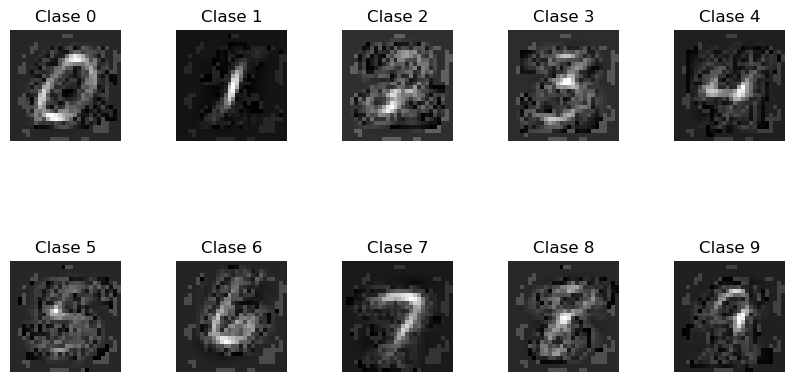

In [28]:
# Definir los placeholders para los datos de entrada x e y_
x = tf.compat.v1.placeholder(tf.float32, shape=(None, 784))
y_ = tf.compat.v1.placeholder(tf.float32, shape=(None, 10))
# Definir las variables W y b con valores iniciales de 0
W = tf.Variable(tf.zeros(shape=(784, 10), dtype=tf.float32))
b = tf.Variable(tf.zeros(shape=(10,), dtype=tf.float32))
# Definir la operación y como la multiplicación matricial de x por W, y luego sumar b
y = tf.matmul(x, W) + b
# Definir lambda como una constante
_lambda = tf.constant(0.01, dtype=tf.float32)
# Calcular regularización L1
l1 = _lambda * tf.reduce_sum(tf.abs(W))
# Definir la función de pérdida
loss = tf.reduce_mean(tf.square(y - y_)) + l1
# Definir el optimizador y la operación de entrenamiento
optimizer = tf.compat.v1.train.GradientDescentOptimizer(0.01)
train_step = optimizer.minimize(loss)
# Inicializar todas las variables globales
init = tf.compat.v1.global_variables_initializer()
# Crear una sesión de TensorFlow y ejecutar la inicialización de variables
sess =  tf.compat.v1.Session()
sess.run(init)

# Definir el número de batches
epochs = 10

# Iterar sobre los batches
for i in range(epochs):
    # Obtener el siguiente batch de datos
    batch_xs = train_images[batch_size*i:(i+1)*batch_size, :, :].reshape(batch_size, 784)
    batch_ys = train_labels[batch_size*i:(i+1)*batch_size, :].reshape(batch_size, 10)
    # Ejecutar una iteración de entrenamiento
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    # Calcular y mostrar la pérdida en el batch actual
    current_loss = sess.run(loss, feed_dict={x: batch_xs, y_: batch_ys})
    print(current_loss)

# Obtener los pesos entrenados
w = sess.run(W)
# Reorganizar los pesos para que tengan la forma (28, 28, 10)
w = w.reshape((28, 28, 10))

# Configurar el tamaño de la figura y el diseño de los subplots
plt.figure(figsize=(10, 5))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# Graficar los pesos de las 10 clases
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(w[:, :, i], cmap='gray')
    plt.title(f'Clase {i}')
    plt.axis('off')

plt.show()

In [23]:
sess.close()

### Red neuronal
Para diseñar una red neuronal en tensorflow el procedimiento es bastante parecido que el que se ha seguido para la regresión lineal. En la siguiente celda vamos a ver como elaborar la misma red neuronal que hemos diseñado al principio de la práctica con KERAS.


In [24]:
sess.close()

In [25]:
# Inicializar las variables
x = tf.compat.v1.placeholder(tf.float32, shape=(None, 784))
y_ = tf.compat.v1.placeholder(tf.float32, shape=(None, 10))

w1 = tf.Variable(tf.compat.v1.truncated_normal((784, 500), stddev=0.1))
w2 = tf.Variable(tf.compat.v1.truncated_normal((500, 500), stddev=0.1))
w3 = tf.Variable(tf.compat.v1.truncated_normal((500, 500), stddev=0.1))
w4 = tf.Variable(tf.compat.v1.truncated_normal((500, 500), stddev=0.1))
w5 = tf.Variable(tf.compat.v1.truncated_normal((500, 500), stddev=0.1))
w6 = tf.Variable(tf.compat.v1.truncated_normal((500, 10), stddev=0.1))

b1 = tf.Variable(tf.constant(0.1, shape=(500,)))
b2 = tf.Variable(tf.constant(0.1, shape=(500,)))
b3 = tf.Variable(tf.constant(0.1, shape=(500,)))
b4 = tf.Variable(tf.constant(0.1, shape=(500,)))
b5 = tf.Variable(tf.constant(0.1, shape=(500,)))
b6 = tf.Variable(tf.constant(0.1, shape=(10,)))

# Definir las operaciones
h1 = tf.nn.relu(tf.matmul(x, w1) + b1)
h2 = tf.nn.relu(tf.matmul(h1, w2) + b2)
h3 = tf.nn.relu(tf.matmul(h2, w3) + b3)
h4 = tf.nn.relu(tf.matmul(h3, w4) + b4)
h5 = tf.nn.relu(tf.matmul(h4, w5) + b5)
y = tf.nn.sigmoid(tf.matmul(h5, w6) + b6)

# Definir la función de pérdida
loss = tf.reduce_mean(tf.square(y - y_))
train_step = tf.compat.v1.train.GradientDescentOptimizer(0.1).minimize(loss)

# Iniciar la sesión
init = tf.compat.v1.global_variables_initializer()
sess = tf.compat.v1.Session()
sess.run(init)

# Correr la sesión
epochs = 10
batch_size = 100
batchs = int(np.shape(train_images)[0]/100)
for i in range(epochs):
    for bi in range(batchs): # iteraciones
        # Obtener el siguiente batch de datos
        batch_xs = train_images[batch_size*bi:(bi+1)*batch_size, :, :].reshape(batch_size, 784)
        batch_ys = train_labels[batch_size*bi:(bi+1)*batch_size, :].reshape(batch_size, 10)
        # Ejecutar una iteración de entrenamiento
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
        
        # Calcular y mostrar la pérdida en el batch actual
        current_loss = sess.run(loss, feed_dict={x: batch_xs, y_: batch_ys})
        print(f"Epoch {i+1}, Loss: {current_loss}")
    
final_loss = sess.run(loss, feed_dict={x: batch_xs, y_: batch_ys})
print(f"Final Loss: {final_loss}")

Epoch 1, Loss: 0.18076196312904358
Epoch 1, Loss: 0.18164297938346863
Epoch 1, Loss: 0.1766476184129715
Epoch 1, Loss: 0.16593460738658905
Epoch 1, Loss: 0.1465940922498703
Epoch 1, Loss: 0.09901577979326248
Epoch 1, Loss: 0.09569871425628662
Epoch 1, Loss: 0.09109599143266678
Epoch 1, Loss: 0.09889375418424606
Epoch 1, Loss: 0.09247197210788727
Epoch 1, Loss: 0.09408155083656311
Epoch 1, Loss: 0.09131329506635666
Epoch 1, Loss: 0.09240195900201797
Epoch 1, Loss: 0.09152546525001526
Epoch 1, Loss: 0.09154757857322693
Epoch 1, Loss: 0.08826102316379547
Epoch 1, Loss: 0.0868426188826561
Epoch 1, Loss: 0.07818660140037537
Epoch 1, Loss: 0.08410702645778656
Epoch 1, Loss: 0.08415868878364563
Epoch 1, Loss: 0.08441726863384247
Epoch 1, Loss: 0.0754934772849083
Epoch 1, Loss: 0.08535728603601456
Epoch 1, Loss: 0.08202670514583588
Epoch 1, Loss: 0.0860992893576622
Epoch 1, Loss: 0.07760322093963623
Epoch 1, Loss: 0.08008436858654022
Epoch 1, Loss: 0.0804673284292221
Epoch 1, Loss: 0.075969681

Epoch 1, Loss: 0.039494194090366364
Epoch 1, Loss: 0.04437432438135147
Epoch 1, Loss: 0.048554085195064545
Epoch 1, Loss: 0.04135874658823013
Epoch 1, Loss: 0.033625196665525436
Epoch 1, Loss: 0.039167214184999466
Epoch 1, Loss: 0.033199504017829895
Epoch 1, Loss: 0.03637019172310829
Epoch 1, Loss: 0.039230018854141235
Epoch 1, Loss: 0.03809022158384323
Epoch 1, Loss: 0.045705970376729965
Epoch 1, Loss: 0.03886216878890991
Epoch 1, Loss: 0.03794538229703903
Epoch 1, Loss: 0.03189651668071747
Epoch 1, Loss: 0.03529542684555054
Epoch 1, Loss: 0.034097082912921906
Epoch 1, Loss: 0.03043682500720024
Epoch 1, Loss: 0.03432178497314453
Epoch 1, Loss: 0.039520829916000366
Epoch 1, Loss: 0.03456243872642517
Epoch 1, Loss: 0.031634245067834854
Epoch 1, Loss: 0.031021639704704285
Epoch 1, Loss: 0.04046157747507095
Epoch 1, Loss: 0.03587595373392105
Epoch 1, Loss: 0.030028419569134712
Epoch 1, Loss: 0.034459151327610016
Epoch 1, Loss: 0.042124513536691666
Epoch 1, Loss: 0.039801716804504395
Epoch

Epoch 1, Loss: 0.03133193403482437
Epoch 1, Loss: 0.040289681404829025
Epoch 1, Loss: 0.03508518263697624
Epoch 1, Loss: 0.026247629895806313
Epoch 1, Loss: 0.027867140248417854
Epoch 1, Loss: 0.02362464927136898
Epoch 1, Loss: 0.026531793177127838
Epoch 1, Loss: 0.02093459479510784
Epoch 1, Loss: 0.021830067038536072
Epoch 1, Loss: 0.03657013550400734
Epoch 1, Loss: 0.031043047085404396
Epoch 1, Loss: 0.03101934678852558
Epoch 1, Loss: 0.028203729540109634
Epoch 1, Loss: 0.026432838290929794
Epoch 1, Loss: 0.025598255917429924
Epoch 1, Loss: 0.016373150050640106
Epoch 1, Loss: 0.01919969543814659
Epoch 1, Loss: 0.02372063882648945
Epoch 1, Loss: 0.02735215425491333
Epoch 1, Loss: 0.029240621253848076
Epoch 1, Loss: 0.020240772515535355
Epoch 1, Loss: 0.017832186073064804
Epoch 1, Loss: 0.022367622703313828
Epoch 1, Loss: 0.022663947194814682
Epoch 1, Loss: 0.021221695467829704
Epoch 1, Loss: 0.02558702789247036
Epoch 1, Loss: 0.02494766190648079
Epoch 1, Loss: 0.033144935965538025
Epo

Epoch 2, Loss: 0.01882929541170597
Epoch 2, Loss: 0.03210730850696564
Epoch 2, Loss: 0.02022581174969673
Epoch 2, Loss: 0.013040982186794281
Epoch 2, Loss: 0.01650804840028286
Epoch 2, Loss: 0.011779440566897392
Epoch 2, Loss: 0.011700103059411049
Epoch 2, Loss: 0.019808059558272362
Epoch 2, Loss: 0.017126033082604408
Epoch 2, Loss: 0.013458283618092537
Epoch 2, Loss: 0.022636329755187035
Epoch 2, Loss: 0.01655508205294609
Epoch 2, Loss: 0.019659373909235
Epoch 2, Loss: 0.022410843521356583
Epoch 2, Loss: 0.021875126287341118
Epoch 2, Loss: 0.014920336194336414
Epoch 2, Loss: 0.02267763577401638
Epoch 2, Loss: 0.027323581278324127
Epoch 2, Loss: 0.03314438834786415
Epoch 2, Loss: 0.019071055576205254
Epoch 2, Loss: 0.012176775373518467
Epoch 2, Loss: 0.007890899665653706
Epoch 2, Loss: 0.020997222512960434
Epoch 2, Loss: 0.01535839680582285
Epoch 2, Loss: 0.013200817629694939
Epoch 2, Loss: 0.013431697152554989
Epoch 2, Loss: 0.015211507678031921
Epoch 2, Loss: 0.012904871255159378
Epo

Epoch 2, Loss: 0.014048886485397816
Epoch 2, Loss: 0.007891707122325897
Epoch 2, Loss: 0.010465257801115513
Epoch 2, Loss: 0.015673188492655754
Epoch 2, Loss: 0.010562983341515064
Epoch 2, Loss: 0.008313269354403019
Epoch 2, Loss: 0.011601959355175495
Epoch 2, Loss: 0.015834849327802658
Epoch 2, Loss: 0.011187209747731686
Epoch 2, Loss: 0.015730690211057663
Epoch 2, Loss: 0.011532546952366829
Epoch 2, Loss: 0.011591867543756962
Epoch 2, Loss: 0.015462758019566536
Epoch 2, Loss: 0.017375530675053596
Epoch 2, Loss: 0.017717307433485985
Epoch 2, Loss: 0.013317517004907131
Epoch 2, Loss: 0.013296987861394882
Epoch 2, Loss: 0.013881033286452293
Epoch 2, Loss: 0.011422957293689251
Epoch 2, Loss: 0.012937911786139011
Epoch 2, Loss: 0.009519055485725403
Epoch 2, Loss: 0.013672985136508942
Epoch 2, Loss: 0.02008921094238758
Epoch 2, Loss: 0.007594400551170111
Epoch 2, Loss: 0.017672091722488403
Epoch 2, Loss: 0.015596807934343815
Epoch 2, Loss: 0.012652004137635231
Epoch 2, Loss: 0.007637890521

Epoch 2, Loss: 0.002765997778624296
Epoch 2, Loss: 0.004701088182628155
Epoch 2, Loss: 0.015113395638763905
Epoch 2, Loss: 0.0011451757745817304
Epoch 2, Loss: 0.010666456073522568
Epoch 3, Loss: 0.006845235824584961
Epoch 3, Loss: 0.011304788291454315
Epoch 3, Loss: 0.0144802900031209
Epoch 3, Loss: 0.005830896086990833
Epoch 3, Loss: 0.01147425640374422
Epoch 3, Loss: 0.014306701719760895
Epoch 3, Loss: 0.017644045874476433
Epoch 3, Loss: 0.010337323881685734
Epoch 3, Loss: 0.014206569641828537
Epoch 3, Loss: 0.013123134151101112
Epoch 3, Loss: 0.02183673530817032
Epoch 3, Loss: 0.01510993205010891
Epoch 3, Loss: 0.01236013788729906
Epoch 3, Loss: 0.013643018901348114
Epoch 3, Loss: 0.005626085214316845
Epoch 3, Loss: 0.013517792336642742
Epoch 3, Loss: 0.0070176078006625175
Epoch 3, Loss: 0.006249498575925827
Epoch 3, Loss: 0.011303468607366085
Epoch 3, Loss: 0.011370847932994366
Epoch 3, Loss: 0.012352271005511284
Epoch 3, Loss: 0.0054857791401445866
Epoch 3, Loss: 0.00938322581350

Epoch 3, Loss: 0.005363662727177143
Epoch 3, Loss: 0.01051344908773899
Epoch 3, Loss: 0.012413683347404003
Epoch 3, Loss: 0.008032320998609066
Epoch 3, Loss: 0.008769568987190723
Epoch 3, Loss: 0.006143153179436922
Epoch 3, Loss: 0.009944950230419636
Epoch 3, Loss: 0.013118959963321686
Epoch 3, Loss: 0.009971349500119686
Epoch 3, Loss: 0.011693031527101994
Epoch 3, Loss: 0.009491605684161186
Epoch 3, Loss: 0.010336602106690407
Epoch 3, Loss: 0.00696971220895648
Epoch 3, Loss: 0.010734817944467068
Epoch 3, Loss: 0.007872787304222584
Epoch 3, Loss: 0.008852308616042137
Epoch 3, Loss: 0.010989506728947163
Epoch 3, Loss: 0.014542310498654842
Epoch 3, Loss: 0.015405655838549137
Epoch 3, Loss: 0.009199250489473343
Epoch 3, Loss: 0.011586027219891548
Epoch 3, Loss: 0.008954498916864395
Epoch 3, Loss: 0.010289144702255726
Epoch 3, Loss: 0.008576181717216969
Epoch 3, Loss: 0.011562729254364967
Epoch 3, Loss: 0.00833809468895197
Epoch 3, Loss: 0.008298797532916069
Epoch 3, Loss: 0.00968461763113

Epoch 3, Loss: 0.007427520118653774
Epoch 3, Loss: 0.007166389841586351
Epoch 3, Loss: 0.007657294161617756
Epoch 3, Loss: 0.006215151399374008
Epoch 3, Loss: 0.020646926015615463
Epoch 3, Loss: 0.008375922217965126
Epoch 3, Loss: 0.010725381784141064
Epoch 3, Loss: 0.00971207208931446
Epoch 3, Loss: 0.01170505490154028
Epoch 3, Loss: 0.009914363734424114
Epoch 3, Loss: 0.005150910466909409
Epoch 3, Loss: 0.012204837054014206
Epoch 3, Loss: 0.007206794805824757
Epoch 3, Loss: 0.0042666844092309475
Epoch 3, Loss: 0.006665467284619808
Epoch 3, Loss: 0.015533627942204475
Epoch 3, Loss: 0.005544319283217192
Epoch 3, Loss: 0.011838497593998909
Epoch 3, Loss: 0.008421303704380989
Epoch 3, Loss: 0.007382277864962816
Epoch 3, Loss: 0.005688613746315241
Epoch 3, Loss: 0.017941923812031746
Epoch 3, Loss: 0.017515873536467552
Epoch 3, Loss: 0.00907256081700325
Epoch 3, Loss: 0.00887275766581297
Epoch 3, Loss: 0.005735090468078852
Epoch 3, Loss: 0.015495830215513706
Epoch 3, Loss: 0.02343067899346

Epoch 4, Loss: 0.0042112283408641815
Epoch 4, Loss: 0.00719192111864686
Epoch 4, Loss: 0.0042055039666593075
Epoch 4, Loss: 0.005965788383036852
Epoch 4, Loss: 0.013390175066888332
Epoch 4, Loss: 0.0057352520525455475
Epoch 4, Loss: 0.009168919175863266
Epoch 4, Loss: 0.00512510584667325
Epoch 4, Loss: 0.00650653475895524
Epoch 4, Loss: 0.00856736395508051
Epoch 4, Loss: 0.0039025391452014446
Epoch 4, Loss: 0.008694562129676342
Epoch 4, Loss: 0.008408659137785435
Epoch 4, Loss: 0.008876806125044823
Epoch 4, Loss: 0.012054839171469212
Epoch 4, Loss: 0.010582548566162586
Epoch 4, Loss: 0.005314176436513662
Epoch 4, Loss: 0.0063537415117025375
Epoch 4, Loss: 0.00770323583856225
Epoch 4, Loss: 0.009672781452536583
Epoch 4, Loss: 0.007965677417814732
Epoch 4, Loss: 0.009159219451248646
Epoch 4, Loss: 0.011782542802393436
Epoch 4, Loss: 0.01540383230894804
Epoch 4, Loss: 0.00762268528342247
Epoch 4, Loss: 0.007479213643819094
Epoch 4, Loss: 0.009924368001520634
Epoch 4, Loss: 0.0199048221111

Epoch 4, Loss: 0.008173851296305656
Epoch 4, Loss: 0.005757283419370651
Epoch 4, Loss: 0.007467945106327534
Epoch 4, Loss: 0.0038685521576553583
Epoch 4, Loss: 0.003943419549614191
Epoch 4, Loss: 0.005947847384959459
Epoch 4, Loss: 0.00551955122500658
Epoch 4, Loss: 0.0037718028761446476
Epoch 4, Loss: 0.007271484937518835
Epoch 4, Loss: 0.012909029610455036
Epoch 4, Loss: 0.009187870658934116
Epoch 4, Loss: 0.010605004616081715
Epoch 4, Loss: 0.009163431823253632
Epoch 4, Loss: 0.010698596946895123
Epoch 4, Loss: 0.007402304094284773
Epoch 4, Loss: 0.004805313888937235
Epoch 4, Loss: 0.008270399644970894
Epoch 4, Loss: 0.007081176619976759
Epoch 4, Loss: 0.006142370868474245
Epoch 4, Loss: 0.010978651233017445
Epoch 4, Loss: 0.0028033689595758915
Epoch 4, Loss: 0.009284330531954765
Epoch 4, Loss: 0.004655941389501095
Epoch 4, Loss: 0.006647731643170118
Epoch 4, Loss: 0.010341078042984009
Epoch 4, Loss: 0.012461069040000439
Epoch 4, Loss: 0.010019822977483273
Epoch 4, Loss: 0.005891081

Epoch 4, Loss: 0.0027608717791736126
Epoch 4, Loss: 0.004601894877851009
Epoch 4, Loss: 0.00477612717077136
Epoch 4, Loss: 0.00577511778101325
Epoch 4, Loss: 0.0030546102207154036
Epoch 4, Loss: 0.005346762947738171
Epoch 4, Loss: 0.008020426146686077
Epoch 4, Loss: 0.007084749173372984
Epoch 4, Loss: 0.00519963912665844
Epoch 4, Loss: 0.010558526031672955
Epoch 4, Loss: 0.010026693344116211
Epoch 4, Loss: 0.0037038547452539206
Epoch 4, Loss: 0.005539157893508673
Epoch 4, Loss: 0.004789621569216251
Epoch 4, Loss: 0.0033683981746435165
Epoch 4, Loss: 0.003311148611828685
Epoch 4, Loss: 0.002239933470264077
Epoch 4, Loss: 0.0074242097325623035
Epoch 4, Loss: 0.005872033070772886
Epoch 4, Loss: 0.003970296587795019
Epoch 4, Loss: 0.00221153162419796
Epoch 4, Loss: 0.005197231192141771
Epoch 4, Loss: 0.0005334028974175453
Epoch 4, Loss: 0.0009115979773923755
Epoch 4, Loss: 0.0027056492399424314
Epoch 4, Loss: 0.004569797310978174
Epoch 4, Loss: 0.009734080173075199
Epoch 4, Loss: 0.0048928

Epoch 5, Loss: 0.00847424753010273
Epoch 5, Loss: 0.00577374454587698
Epoch 5, Loss: 0.003138279542326927
Epoch 5, Loss: 0.008865747600793839
Epoch 5, Loss: 0.009109895676374435
Epoch 5, Loss: 0.012915021739900112
Epoch 5, Loss: 0.008983581326901913
Epoch 5, Loss: 0.012549562379717827
Epoch 5, Loss: 0.008412729017436504
Epoch 5, Loss: 0.007521891500800848
Epoch 5, Loss: 0.002510696416720748
Epoch 5, Loss: 0.006705898325890303
Epoch 5, Loss: 0.004641532897949219
Epoch 5, Loss: 0.007464410737156868
Epoch 5, Loss: 0.007516800891608
Epoch 5, Loss: 0.004109226167201996
Epoch 5, Loss: 0.002241741633042693
Epoch 5, Loss: 0.006813732907176018
Epoch 5, Loss: 0.0036330376751720905
Epoch 5, Loss: 0.010596750304102898
Epoch 5, Loss: 0.01407609973102808
Epoch 5, Loss: 0.0018195138545706868
Epoch 5, Loss: 0.009719387628138065
Epoch 5, Loss: 0.021158305928111076
Epoch 5, Loss: 0.014314524829387665
Epoch 5, Loss: 0.00688751507550478
Epoch 5, Loss: 0.0050361305475234985
Epoch 5, Loss: 0.003192977979779

Epoch 5, Loss: 0.004005509428679943
Epoch 5, Loss: 0.011613350361585617
Epoch 5, Loss: 0.009801574982702732
Epoch 5, Loss: 0.008385756984353065
Epoch 5, Loss: 0.006264622788876295
Epoch 5, Loss: 0.010873795486986637
Epoch 5, Loss: 0.010514585301280022
Epoch 5, Loss: 0.014023678377270699
Epoch 5, Loss: 0.0084785595536232
Epoch 5, Loss: 0.011723401956260204
Epoch 5, Loss: 0.014888552948832512
Epoch 5, Loss: 0.010229437611997128
Epoch 5, Loss: 0.0025196822825819254
Epoch 5, Loss: 0.006057645659893751
Epoch 5, Loss: 0.006726850755512714
Epoch 5, Loss: 0.005102434195578098
Epoch 5, Loss: 0.005508593749254942
Epoch 5, Loss: 0.006270697806030512
Epoch 5, Loss: 0.004434879403561354
Epoch 5, Loss: 0.017118126153945923
Epoch 5, Loss: 0.0056883362121880054
Epoch 5, Loss: 0.008836156688630581
Epoch 5, Loss: 0.007744730915874243
Epoch 5, Loss: 0.007644954603165388
Epoch 5, Loss: 0.0076330890879035
Epoch 5, Loss: 0.0034949290566146374
Epoch 5, Loss: 0.00955294631421566
Epoch 5, Loss: 0.0049156025052

Epoch 6, Loss: 0.010679223574697971
Epoch 6, Loss: 0.004296870902180672
Epoch 6, Loss: 0.00798551831394434
Epoch 6, Loss: 0.0038002957589924335
Epoch 6, Loss: 0.004401296842843294
Epoch 6, Loss: 0.0066683292388916016
Epoch 6, Loss: 0.002279173582792282
Epoch 6, Loss: 0.005354082211852074
Epoch 6, Loss: 0.005873189773410559
Epoch 6, Loss: 0.007174015045166016
Epoch 6, Loss: 0.00834375899285078
Epoch 6, Loss: 0.008179726079106331
Epoch 6, Loss: 0.004128383472561836
Epoch 6, Loss: 0.004478678107261658
Epoch 6, Loss: 0.005789380054920912
Epoch 6, Loss: 0.007353371009230614
Epoch 6, Loss: 0.00564924068748951
Epoch 6, Loss: 0.006259421817958355
Epoch 6, Loss: 0.009077751077711582
Epoch 6, Loss: 0.012969420291483402
Epoch 6, Loss: 0.005855041556060314
Epoch 6, Loss: 0.005611861124634743
Epoch 6, Loss: 0.006965627893805504
Epoch 6, Loss: 0.015317548997700214
Epoch 6, Loss: 0.00839221477508545
Epoch 6, Loss: 0.004480149131268263
Epoch 6, Loss: 0.004449060186743736
Epoch 6, Loss: 0.0055103176273

Epoch 6, Loss: 0.004963223356753588
Epoch 6, Loss: 0.01073238905519247
Epoch 6, Loss: 0.007664825301617384
Epoch 6, Loss: 0.008073794655501842
Epoch 6, Loss: 0.007966356351971626
Epoch 6, Loss: 0.008807940408587456
Epoch 6, Loss: 0.005696451291441917
Epoch 6, Loss: 0.004145655315369368
Epoch 6, Loss: 0.0066742440685629845
Epoch 6, Loss: 0.005702740512788296
Epoch 6, Loss: 0.0048882365226745605
Epoch 6, Loss: 0.00975690595805645
Epoch 6, Loss: 0.0018519675359129906
Epoch 6, Loss: 0.0073412139900028706
Epoch 6, Loss: 0.003624875098466873
Epoch 6, Loss: 0.004401201382279396
Epoch 6, Loss: 0.006079134531319141
Epoch 6, Loss: 0.009667099453508854
Epoch 6, Loss: 0.008073645643889904
Epoch 6, Loss: 0.005053890403360128
Epoch 6, Loss: 0.005716026294976473
Epoch 6, Loss: 0.009708774276077747
Epoch 6, Loss: 0.004208122845739126
Epoch 6, Loss: 0.0030730636790394783
Epoch 6, Loss: 0.0062688677571713924
Epoch 6, Loss: 0.008292377926409245
Epoch 6, Loss: 0.005995753221213818
Epoch 6, Loss: 0.0085819

Epoch 6, Loss: 0.0037835908588021994
Epoch 6, Loss: 0.004181847907602787
Epoch 6, Loss: 0.0024196740705519915
Epoch 6, Loss: 0.002300170948728919
Epoch 6, Loss: 0.0013411178952082992
Epoch 6, Loss: 0.006189137231558561
Epoch 6, Loss: 0.00374212465249002
Epoch 6, Loss: 0.002932964824140072
Epoch 6, Loss: 0.0014489289605990052
Epoch 6, Loss: 0.0040510473772883415
Epoch 6, Loss: 0.00045043922727927566
Epoch 6, Loss: 0.0005371429724618793
Epoch 6, Loss: 0.0013399318559095263
Epoch 6, Loss: 0.003926834091544151
Epoch 6, Loss: 0.008392171934247017
Epoch 6, Loss: 0.003035761881619692
Epoch 6, Loss: 0.0009932899847626686
Epoch 6, Loss: 0.0022270174231380224
Epoch 6, Loss: 0.013652252033352852
Epoch 6, Loss: 0.00044166677980683744
Epoch 6, Loss: 0.006532563362270594
Epoch 7, Loss: 0.0038875245954841375
Epoch 7, Loss: 0.00662384694442153
Epoch 7, Loss: 0.009274415671825409
Epoch 7, Loss: 0.002428903942927718
Epoch 7, Loss: 0.00665219034999609
Epoch 7, Loss: 0.0075462497770786285
Epoch 7, Loss: 0

Epoch 7, Loss: 0.006211335305124521
Epoch 7, Loss: 0.006009887903928757
Epoch 7, Loss: 0.0028219919186085463
Epoch 7, Loss: 0.0015744507545605302
Epoch 7, Loss: 0.006106110755354166
Epoch 7, Loss: 0.003201143816113472
Epoch 7, Loss: 0.008808431215584278
Epoch 7, Loss: 0.011556684039533138
Epoch 7, Loss: 0.0014633341925218701
Epoch 7, Loss: 0.008612019009888172
Epoch 7, Loss: 0.01753806509077549
Epoch 7, Loss: 0.013060149736702442
Epoch 7, Loss: 0.0053275651298463345
Epoch 7, Loss: 0.0030354484915733337
Epoch 7, Loss: 0.0022411621175706387
Epoch 7, Loss: 0.007934591732919216
Epoch 7, Loss: 0.0069466703571379185
Epoch 7, Loss: 0.005403438117355108
Epoch 7, Loss: 0.003453207900747657
Epoch 7, Loss: 0.00256918603554368
Epoch 7, Loss: 0.005500234197825193
Epoch 7, Loss: 0.006537046283483505
Epoch 7, Loss: 0.005786579102277756
Epoch 7, Loss: 0.007147057447582483
Epoch 7, Loss: 0.00636467058211565
Epoch 7, Loss: 0.006860384717583656
Epoch 7, Loss: 0.00414056284353137
Epoch 7, Loss: 0.00627338

Epoch 7, Loss: 0.007654938846826553
Epoch 7, Loss: 0.006877176463603973
Epoch 7, Loss: 0.005439594388008118
Epoch 7, Loss: 0.008936204947531223
Epoch 7, Loss: 0.008399102836847305
Epoch 7, Loss: 0.011982176452875137
Epoch 7, Loss: 0.007318501360714436
Epoch 7, Loss: 0.0100509412586689
Epoch 7, Loss: 0.01280960626900196
Epoch 7, Loss: 0.00792989507317543
Epoch 7, Loss: 0.0019808667711913586
Epoch 7, Loss: 0.004794965963810682
Epoch 7, Loss: 0.005585998762398958
Epoch 7, Loss: 0.0035179415717720985
Epoch 7, Loss: 0.0036935224197804928
Epoch 7, Loss: 0.0056364950723946095
Epoch 7, Loss: 0.0037449125666171312
Epoch 7, Loss: 0.015060407109558582
Epoch 7, Loss: 0.004749307408928871
Epoch 7, Loss: 0.007846237160265446
Epoch 7, Loss: 0.00635581323876977
Epoch 7, Loss: 0.006191557738929987
Epoch 7, Loss: 0.005634779576212168
Epoch 7, Loss: 0.0029085264541208744
Epoch 7, Loss: 0.008314655162394047
Epoch 7, Loss: 0.003824247047305107
Epoch 7, Loss: 0.0022926589008420706
Epoch 7, Loss: 0.004347560

Epoch 8, Loss: 0.00815122202038765
Epoch 8, Loss: 0.006117669865489006
Epoch 8, Loss: 0.0022673429921269417
Epoch 8, Loss: 0.006269797217100859
Epoch 8, Loss: 0.0020967719610780478
Epoch 8, Loss: 0.001959087559953332
Epoch 8, Loss: 0.005383712239563465
Epoch 8, Loss: 0.0023152753710746765
Epoch 8, Loss: 0.0082087442278862
Epoch 8, Loss: 0.0025722994469106197
Epoch 8, Loss: 0.003391221398487687
Epoch 8, Loss: 0.0017164901364594698
Epoch 8, Loss: 0.003038909751921892
Epoch 8, Loss: 0.008874570950865746
Epoch 8, Loss: 0.003542820457369089
Epoch 8, Loss: 0.006740713957697153
Epoch 8, Loss: 0.003441690467298031
Epoch 8, Loss: 0.0034779272973537445
Epoch 8, Loss: 0.005249124485999346
Epoch 8, Loss: 0.0011013614712283015
Epoch 8, Loss: 0.0035388211254030466
Epoch 8, Loss: 0.004766538739204407
Epoch 8, Loss: 0.006403179373592138
Epoch 8, Loss: 0.006300510372966528
Epoch 8, Loss: 0.007071150932461023
Epoch 8, Loss: 0.0034412923268973827
Epoch 8, Loss: 0.003650591941550374
Epoch 8, Loss: 0.00449

Epoch 8, Loss: 0.00893207173794508
Epoch 8, Loss: 0.004986858461052179
Epoch 8, Loss: 0.004845849703997374
Epoch 8, Loss: 0.003009467152878642
Epoch 8, Loss: 0.005523246712982655
Epoch 8, Loss: 0.002082365332171321
Epoch 8, Loss: 0.0018579264869913459
Epoch 8, Loss: 0.004931994713842869
Epoch 8, Loss: 0.0030982475727796555
Epoch 8, Loss: 0.0017299826722592115
Epoch 8, Loss: 0.0037841706071048975
Epoch 8, Loss: 0.009622695855796337
Epoch 8, Loss: 0.0067192730493843555
Epoch 8, Loss: 0.0065515851601958275
Epoch 8, Loss: 0.007379100192338228
Epoch 8, Loss: 0.007607985753566027
Epoch 8, Loss: 0.004760383628308773
Epoch 8, Loss: 0.0037674221675843
Epoch 8, Loss: 0.005602611694484949
Epoch 8, Loss: 0.004848524462431669
Epoch 8, Loss: 0.004240894690155983
Epoch 8, Loss: 0.009189964272081852
Epoch 8, Loss: 0.0012814197689294815
Epoch 8, Loss: 0.006424679886549711
Epoch 8, Loss: 0.0029133986681699753
Epoch 8, Loss: 0.003489142982289195
Epoch 8, Loss: 0.004357113037258387
Epoch 8, Loss: 0.008057

Epoch 8, Loss: 0.0013306871987879276
Epoch 8, Loss: 0.003100465750321746
Epoch 8, Loss: 0.002423622412607074
Epoch 8, Loss: 0.003773331642150879
Epoch 8, Loss: 0.0013426177902147174
Epoch 8, Loss: 0.001998522086068988
Epoch 8, Loss: 0.00474119046702981
Epoch 8, Loss: 0.004555192776024342
Epoch 8, Loss: 0.002613899065181613
Epoch 8, Loss: 0.008345390670001507
Epoch 8, Loss: 0.0071177491918206215
Epoch 8, Loss: 0.0021377154625952244
Epoch 8, Loss: 0.0029547701124101877
Epoch 8, Loss: 0.003732682904228568
Epoch 8, Loss: 0.001969145843759179
Epoch 8, Loss: 0.0018207499524578452
Epoch 8, Loss: 0.0009001183789223433
Epoch 8, Loss: 0.005177662707865238
Epoch 8, Loss: 0.0024314781185239553
Epoch 8, Loss: 0.002476641908288002
Epoch 8, Loss: 0.0010536706540733576
Epoch 8, Loss: 0.0034186244010925293
Epoch 8, Loss: 0.0004165950231254101
Epoch 8, Loss: 0.0003747057926375419
Epoch 8, Loss: 0.0006812504143454134
Epoch 8, Loss: 0.0032833199948072433
Epoch 8, Loss: 0.007745285984128714
Epoch 8, Loss: 

Epoch 9, Loss: 0.0071662901900708675
Epoch 9, Loss: 0.009133955463767052
Epoch 9, Loss: 0.005924788303673267
Epoch 9, Loss: 0.009418767876923084
Epoch 9, Loss: 0.006584627088159323
Epoch 9, Loss: 0.005591974128037691
Epoch 9, Loss: 0.0013591856695711613
Epoch 9, Loss: 0.003685426665470004
Epoch 9, Loss: 0.0023819811176508665
Epoch 9, Loss: 0.005499229300767183
Epoch 9, Loss: 0.0048902686685323715
Epoch 9, Loss: 0.0021510689985007048
Epoch 9, Loss: 0.0011992475483566523
Epoch 9, Loss: 0.0057803611271083355
Epoch 9, Loss: 0.0027316035702824593
Epoch 9, Loss: 0.007709002587944269
Epoch 9, Loss: 0.009559263475239277
Epoch 9, Loss: 0.0013303436571732163
Epoch 9, Loss: 0.008008922450244427
Epoch 9, Loss: 0.014303503558039665
Epoch 9, Loss: 0.012359606102108955
Epoch 9, Loss: 0.004177846014499664
Epoch 9, Loss: 0.002172264503315091
Epoch 9, Loss: 0.0017110517947003245
Epoch 9, Loss: 0.006983988918364048
Epoch 9, Loss: 0.005949231795966625
Epoch 9, Loss: 0.004527762532234192
Epoch 9, Loss: 0.0

Epoch 9, Loss: 0.0027987847570329905
Epoch 9, Loss: 0.0032594245858490467
Epoch 9, Loss: 0.003994807600975037
Epoch 9, Loss: 0.008365747518837452
Epoch 9, Loss: 0.00492513831704855
Epoch 9, Loss: 0.008163640275597572
Epoch 9, Loss: 0.004205438774079084
Epoch 9, Loss: 0.005079794675111771
Epoch 9, Loss: 0.003084892639890313
Epoch 9, Loss: 0.007053150795400143
Epoch 9, Loss: 0.005897220689803362
Epoch 9, Loss: 0.005914747714996338
Epoch 9, Loss: 0.0050091673620045185
Epoch 9, Loss: 0.007742057554423809
Epoch 9, Loss: 0.007218008395284414
Epoch 9, Loss: 0.010376550257205963
Epoch 9, Loss: 0.006313912570476532
Epoch 9, Loss: 0.009242824278771877
Epoch 9, Loss: 0.0112195685505867
Epoch 9, Loss: 0.006929293740540743
Epoch 9, Loss: 0.0013571948511525989
Epoch 9, Loss: 0.003536903765052557
Epoch 9, Loss: 0.004849223420023918
Epoch 9, Loss: 0.002477237256243825
Epoch 9, Loss: 0.0024897425901144743
Epoch 9, Loss: 0.005307397805154324
Epoch 9, Loss: 0.003277919488027692
Epoch 9, Loss: 0.013713555

Epoch 10, Loss: 0.003783472115173936
Epoch 10, Loss: 0.0070286281406879425
Epoch 10, Loss: 0.00509597035124898
Epoch 10, Loss: 0.0030712606385350227
Epoch 10, Loss: 0.002781444462016225
Epoch 10, Loss: 0.005764472298324108
Epoch 10, Loss: 0.009829404763877392
Epoch 10, Loss: 0.0022036698646843433
Epoch 10, Loss: 0.008301220834255219
Epoch 10, Loss: 0.002521706046536565
Epoch 10, Loss: 0.007713763043284416
Epoch 10, Loss: 0.009693498723208904
Epoch 10, Loss: 0.008110118098556995
Epoch 10, Loss: 0.005443621426820755
Epoch 10, Loss: 0.003688322613015771
Epoch 10, Loss: 0.004874450154602528
Epoch 10, Loss: 0.005205420311540365
Epoch 10, Loss: 0.003176565747708082
Epoch 10, Loss: 0.0072644418105483055
Epoch 10, Loss: 0.004872625228017569
Epoch 10, Loss: 0.0015017535770311952
Epoch 10, Loss: 0.0048387134447693825
Epoch 10, Loss: 0.001499811070971191
Epoch 10, Loss: 0.0017626439221203327
Epoch 10, Loss: 0.0049149650149047375
Epoch 10, Loss: 0.001889144303277135
Epoch 10, Loss: 0.0082974378019

Epoch 10, Loss: 0.007100346498191357
Epoch 10, Loss: 0.004257685504853725
Epoch 10, Loss: 0.005691143684089184
Epoch 10, Loss: 0.005203419830650091
Epoch 10, Loss: 0.004240905866026878
Epoch 10, Loss: 0.009628438390791416
Epoch 10, Loss: 0.0047937678173184395
Epoch 10, Loss: 0.00988762266933918
Epoch 10, Loss: 0.006514889653772116
Epoch 10, Loss: 0.007002098020166159
Epoch 10, Loss: 0.009393093176186085
Epoch 10, Loss: 0.009493805468082428
Epoch 10, Loss: 0.0049555194564163685
Epoch 10, Loss: 0.0062772659584879875
Epoch 10, Loss: 0.005235739052295685
Epoch 10, Loss: 0.005825850181281567
Epoch 10, Loss: 0.004081544000655413
Epoch 10, Loss: 0.004810410086065531
Epoch 10, Loss: 0.0073523325845599174
Epoch 10, Loss: 0.0026658442802727222
Epoch 10, Loss: 0.0042273178696632385
Epoch 10, Loss: 0.00416859844699502
Epoch 10, Loss: 0.0053984927944839
Epoch 10, Loss: 0.0025433816481381655
Epoch 10, Loss: 0.00312583870254457
Epoch 10, Loss: 0.004069024696946144
Epoch 10, Loss: 0.001652711420319974

Epoch 10, Loss: 0.007426647003740072
Epoch 10, Loss: 0.006343355402350426
Epoch 10, Loss: 0.004071453120559454
Epoch 10, Loss: 0.0061052944511175156
Epoch 10, Loss: 0.006207676604390144
Epoch 10, Loss: 0.007155253551900387
Epoch 10, Loss: 0.0024526468478143215
Epoch 10, Loss: 0.003798123449087143
Epoch 10, Loss: 0.0033438988029956818
Epoch 10, Loss: 0.002278087427839637
Epoch 10, Loss: 0.00766325369477272
Epoch 10, Loss: 0.0024741569068282843
Epoch 10, Loss: 0.0017903756815940142
Epoch 10, Loss: 0.0060069868341088295
Epoch 10, Loss: 0.00924361776560545
Epoch 10, Loss: 0.004534988198429346
Epoch 10, Loss: 0.007216364610940218
Epoch 10, Loss: 0.0029302912298589945
Epoch 10, Loss: 0.0031056185252964497
Epoch 10, Loss: 0.0023709391243755817
Epoch 10, Loss: 0.0020983193535357714
Epoch 10, Loss: 0.0020343693904578686
Epoch 10, Loss: 0.0060851383022964
Epoch 10, Loss: 0.004775389097630978
Epoch 10, Loss: 0.0015844962326809764
Epoch 10, Loss: 0.00386557774618268
Epoch 10, Loss: 0.0009362447308

In [26]:
file_writer = tf.compat.v1.summary.FileWriter("graph", sess.graph)
file_writer.close()
sess.close()

Podemos visualizar la red con los comandos descritos anteriormente:

In [27]:
# Cargar la extensión de TensorBoard para notebook
%load_ext tensorboard

# Iniciar TensorBoard dentro del notebook
%tensorboard --logdir=graph

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 89955), started 0:01:36 ago. (Use '!kill 89955' to kill it.)

# Crea un red neuronal que se ajuste al dataset cifar10

In [31]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

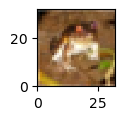

In [32]:
fig = plt.figure(figsize = (1, 1))
plt.pcolormesh(np.flipud(x_train[0,:,:]))

In [44]:
# normalize data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = to_categorical(y_train, 10)# 10 son el número de clases
y_test = to_categorical(y_test, 10)